In [15]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

Read all files

In [19]:
#1_trial is a name of a folder containing the cali files, you may create a folder with a different name and replace the folder name here
tk = th.Thicket.from_caliperreader(sorted(glob("../Cali_Files/*/*/*perturbed*.cali")))

(2/2) Creating Thicket: 100%|██████████| 249/249 [00:04<00:00, 61.47it/s] 
c:\Users\ximin\AppData\Local\Programs\Python\Python310\lib\site-packages\thicket\ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


View Calltree

In [ ]:
print(tk.tree(metric_column="Avg time/rank"))

In [ ]:
tk.metadata

Group Performance data by `matrix_size` in the Thicket metadata table.

In [20]:
tk.metadata_column_to_perfdata("num_procs")
tk.metadata_column_to_perfdata("algorithm")
tk.metadata_column_to_perfdata("input_size")

#tk.dataframe = tk.dataframe.reset_index().set_index(["node", "num_procs", "input_size", "input_type"]).sort_index()
tk.dataframe = tk.dataframe.reset_index()
tk.dataframe = tk.dataframe[tk.dataframe['num_procs'] != 1024]

# tk.dataframe

In [ ]:
# Define common variables
processes = [2, 4, 8, 16, 32, 64]
matrix_sizes = [128, 1024, 8192]

In [ ]:
# Change font size for all plots
plt.rcParams.update({"font.size": 20})

In [ ]:
def plot_pandas(df, title, xlabel, ylabel):
    #styles = ['-', '--', ':']
    plot = df.plot(kind="line", 
        marker='o', 
        title=title, 
        xlabel=xlabel,
        ylabel=ylabel, 
        figsize=(15,7),
        #style=styles
    )
    
    return plot

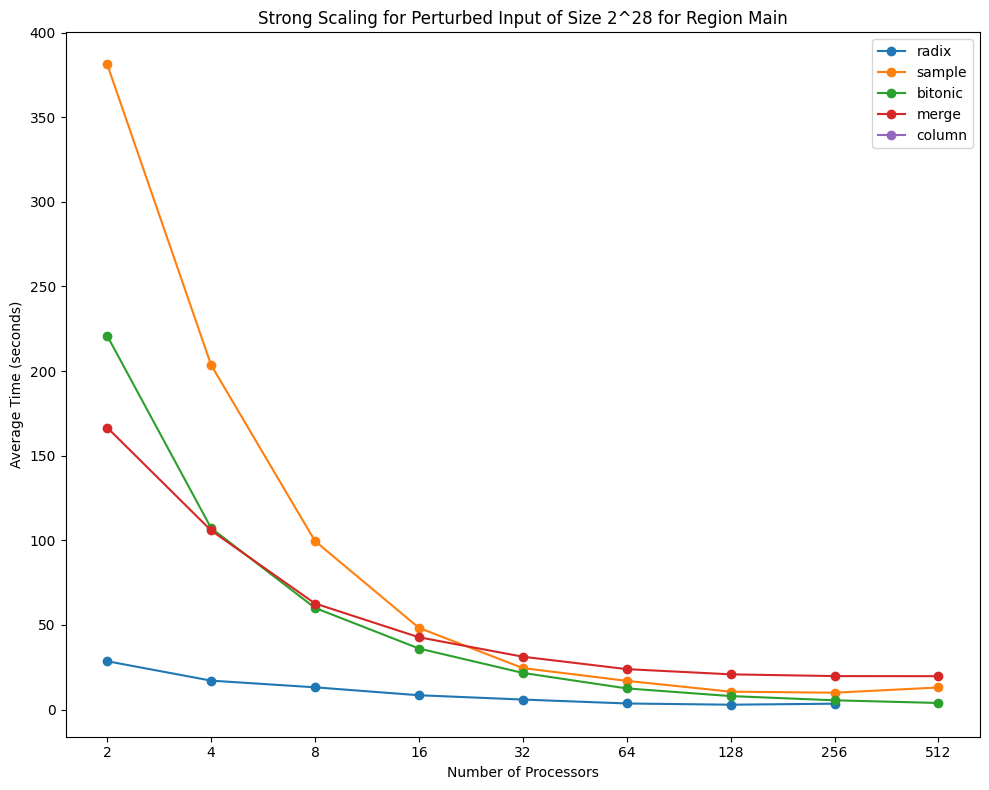

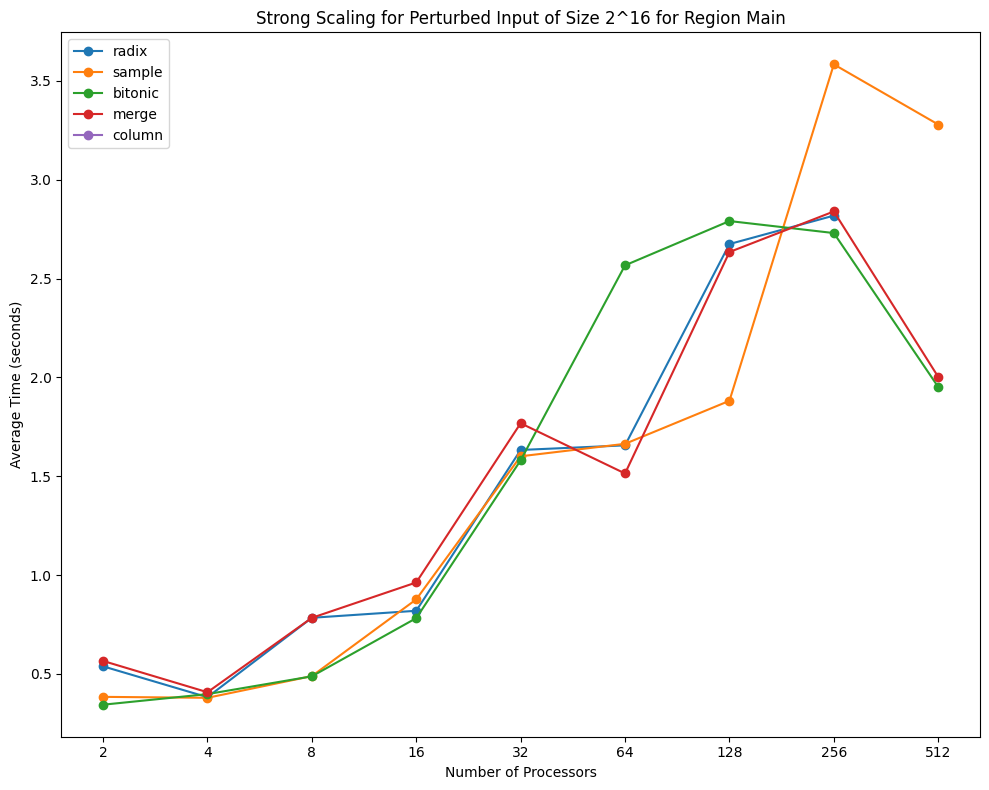

In [22]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# input_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
input_sizes = [268435456]

# Custom formatter function to show integers instead of 2^1, 2^2, etc.
def log_formatter(x, pos):
    return f'{int(x):d}'

def plot_strong_scaling(tk, input_sizes):
    node_names = ['main']  # We will plot these regions
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    
    for node_name in node_names:  # Iterate through axes and node names
        for node in tk.graph.traverse():
            if node.frame['name'] == node_name:
                comp_node = node
                break

        if node.frame['name'] == node_name:
            for input_size in input_sizes:
                for algorithm in ["radix", "sample", "bitonic", "merge", "column"]:
                    data = tk.dataframe[(tk.dataframe["algorithm"] == algorithm) & 
                                        (tk.dataframe["input_size"] == input_size) & 
                                        (tk.dataframe['node'] == comp_node)]
                    data = data.sort_values(by="num_procs")
                    ax.plot(data["num_procs"], data["Avg time/rank"], marker='o', label=algorithm)

                # Set title, labels, and legend for each subplot
                ax.set_title(f'Strong Scaling for Perturbed Input of Size 2^{int(math.log2(input_size))} for Region Main')
                ax.set_xlabel('Number of Processors')
                ax.set_ylabel('Average Time (seconds)')
                ax.legend()

                # Set x-axis to log scale (base 2)
                ax.set_xscale('log', base=2)

                # Set specific x-ticks
                ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512]
                ax.set_xticks(ticks)

                # Use FuncFormatter to label ticks as plain integers
                ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))


    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()
    

plot_strong_scaling(tk, [268435456])
plot_strong_scaling(tk, [65536])


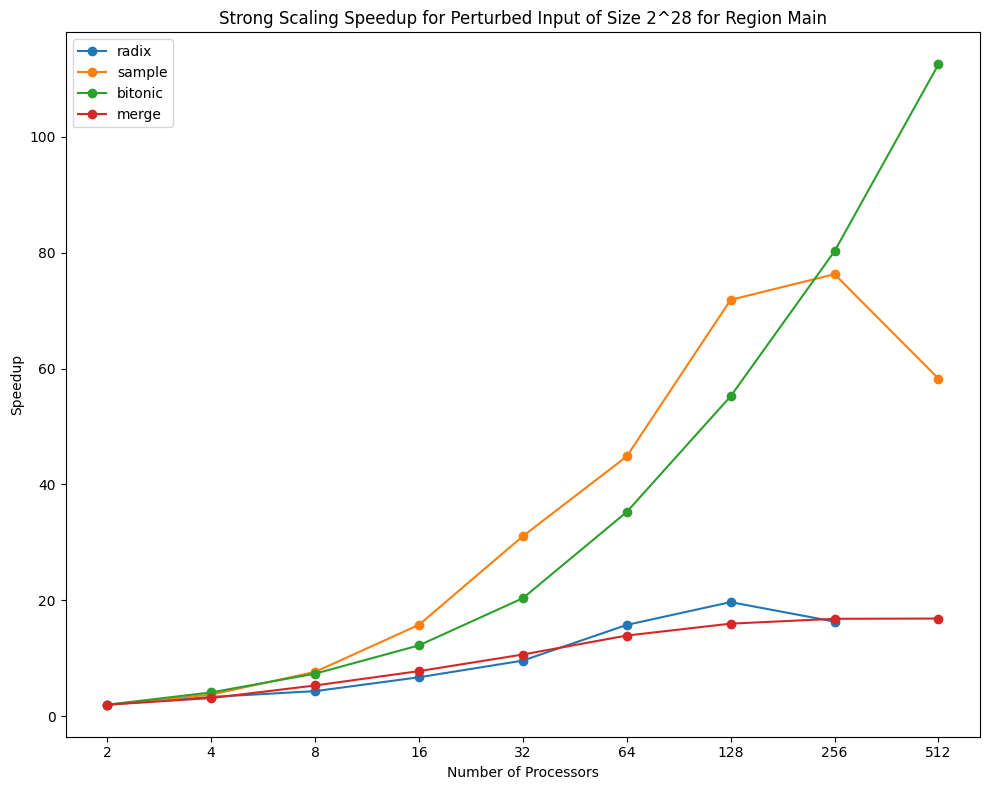

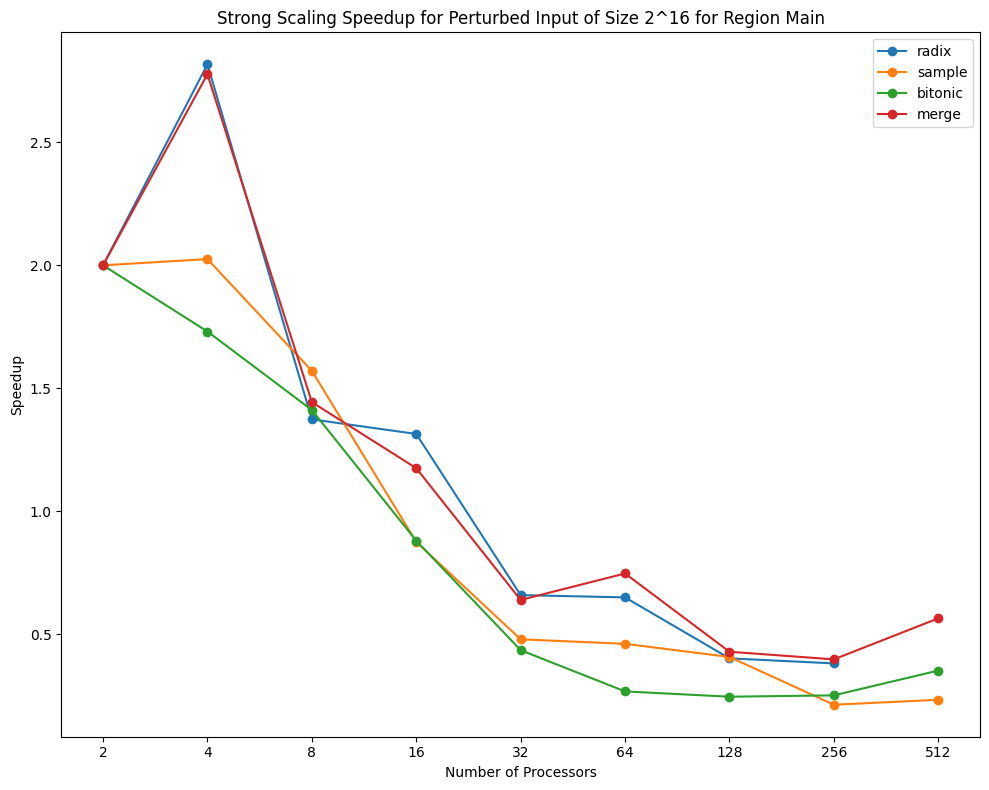

In [23]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# input_sizes = [65536, 262144, 1048576, 4194304, 16777216, 67108864, 268435456]
input_sizes = [268435456]

# Custom formatter function to show integers instead of 2^1, 2^2, etc.
def log_formatter(x, pos):
    return f'{int(x):d}'

def plot_strong_scaling_speedup(tk, input_sizes):
    node_names = ['main']  # We will plot these regions
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    
    for node_name in node_names:  # Iterate through axes and node names
        for node in tk.graph.traverse():
            if node.frame['name'] == node_name:
                comp_node = node
                break

        if node.frame['name'] == node_name:
            for input_size in input_sizes:
                for algorithm in ["radix", "sample", "bitonic", "merge"]:
                    data = tk.dataframe[(tk.dataframe["algorithm"] == algorithm) & 
                                        (tk.dataframe["input_size"] == input_size) & 
                                        (tk.dataframe['node'] == comp_node)]
                    data = data.sort_values(by="num_procs")

                    # Get the average time for 2 processors to normalize the speedup
                    time_for_2_procs = 2 * data.loc[data["num_procs"] == 2, "Avg time/rank"].values[0]

                    # Compute speedup by dividing time for 2 processors by the current time
                    speedup = time_for_2_procs / data["Avg time/rank"]

                    ax.plot(data["num_procs"], speedup, marker='o', label=algorithm)

                # Set title, labels, and legend for each subplot
                ax.set_title(f'Strong Scaling Speedup for Perturbed Input of Size 2^{int(math.log2(input_size))} for Region Main')
                ax.set_xlabel('Number of Processors')
                ax.set_ylabel('Speedup')
                ax.legend()

                # Set x-axis to log scale (base 2)
                ax.set_xscale('log', base=2)

                # Set specific x-ticks
                ticks = [2, 4, 8, 16, 32, 64, 128, 256, 512]
                ax.set_xticks(ticks)

                # Use FuncFormatter to label ticks as plain integers
                ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))


    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()
    

plot_strong_scaling_speedup(tk, [268435456])
plot_strong_scaling_speedup(tk, [65536])


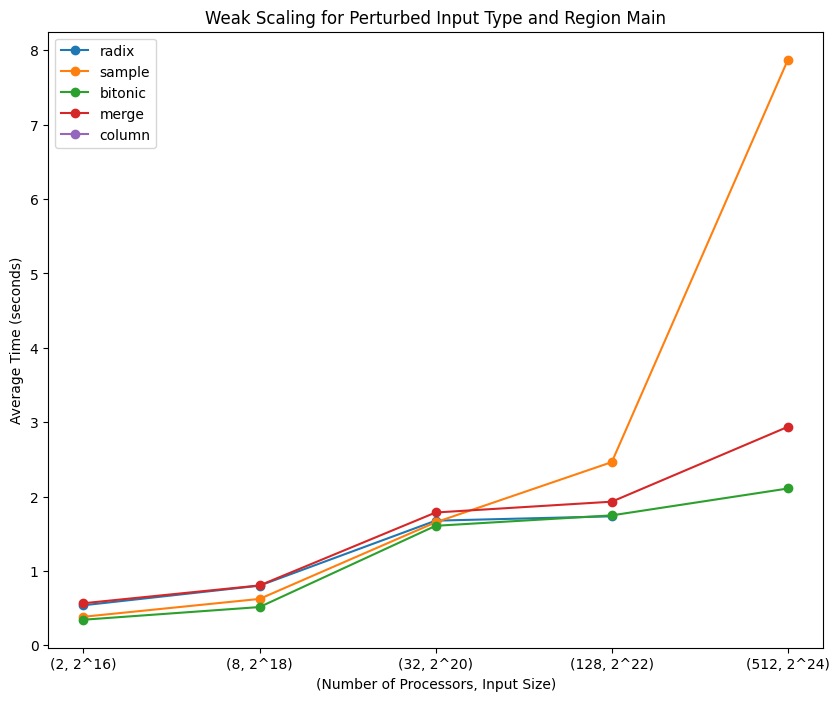

In [24]:
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

input_sizes = [65536, 262144, 1048576, 4194304, 16777216]
num_procs_list = [2, 8, 32, 128, 512]  # The processors corresponding to each input size

# Custom formatter to show (num_procs, 2^input_size_exponent) format
def log_formatter(x, pos):
    num_procs_exp_map = {
        2: 16,  # 2^16
        8: 18,  # 2^18
        32: 20, # 2^20
        128: 22, # 2^22
        512: 24  # 2^24
    }
    if x in num_procs_exp_map:
        return f'({int(x)}, 2^{num_procs_exp_map[int(x)]})'
    return ''

def plot_weak_scaling(tk, input_sizes, num_procs_list):
    algorithms = ["radix", "sample", "bitonic", "merge", "column"]
    plt.figure(figsize=(10,8))
    ax = plt.gca()

    for node in tk.graph.traverse():
        if node.frame['name'] == 'main':
            comp_node = node
            break


    for algorithm in algorithms:
        # Create empty lists to store the points
        x_vals = []
        y_vals = []
        for num_procs, input_size in zip(num_procs_list, input_sizes):  # Iterate through specific points
            data = tk.dataframe[(tk.dataframe["algorithm"] == algorithm) & 
                                (tk.dataframe["input_size"] == input_size) & 
                                (tk.dataframe['num_procs'] == num_procs) & 
                                (tk.dataframe['node'] == comp_node)]  # Filter for exact (num_procs, input_size)
            data = data.sort_values(by="num_procs")

            # Append the data points to the lists
            if not data.empty:  # Ensure there is data to plot
                x_vals.append(num_procs)
                y_vals.append(data["Avg time/rank"].values[0])  # Get the average time for the point

        # Plot the line connecting the points
        ax.plot(x_vals, y_vals, marker='o', label=algorithm)

    # Set title, labels, and legend for each subplot
    ax.set_title(f'Weak Scaling for Perturbed Input Type and Region Main')
    ax.set_xlabel('(Number of Processors, Input Size)')
    ax.set_ylabel('Average Time (seconds)')
    ax.legend()

    # Set x-axis to log scale (base 2)
    ax.set_xscale('log', base=2)

    # Set specific x-ticks
    ticks = num_procs_list  # Set x-ticks to match the exact processor values
    ax.set_xticks(ticks)

    # Use FuncFormatter to label ticks in the desired format
    ax.xaxis.set_major_formatter(FuncFormatter(log_formatter))

    plt.show()

plot_weak_scaling(tk, input_sizes, num_procs_list)
